In [ ]:
!pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=7d4e5d78dded0ae94646ccb6c93c58cdb760e05682c6ce610172e8b204b4eae6
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [ ]:
import import_ipynb
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! pwd
%cd drive/MyDrive
%cd Colab-Super_resolution/

Mounted at /content/drive
/content
/content/drive/MyDrive
/content/drive/.shortcut-targets-by-id/1YQRZ4J0XiIT4NXBt9kvXgpNEbEp588R7/Colab-Super_resolution


#Loading and visualize dataset

In [ ]:
import LoadingDataset  as dataset_loader

importing Jupyter notebook from LoadingDataset.ipynb
import libary...


In [ ]:
dataset=dataset_loader.load_dataset(key='div2k/bicubic_x4')

using tensorflow_datasets to load the dataset 
loading dataset...
tfds.core.DatasetInfo(
    name='div2k',
    version=2.0.0,
    description='DIV2K dataset: DIVerse 2K resolution high quality images as used for the challenges @ NTIRE (CVPR 2017 and CVPR 2018) and @ PIRM (ECCV 2018)',
    homepage='https://data.vision.ee.ethz.ch/cvl/DIV2K/',
    features=FeaturesDict({
        'hr': Image(shape=(None, None, 3), dtype=tf.uint8),
        'lr': Image(shape=(None, None, 3), dtype=tf.uint8),
    }),
    total_num_examples=900,
    splits={
        'train': 800,
        'validation': 100,
    },
    supervised_keys=('lr', 'hr'),
    citation="""@InProceedings{Agustsson_2017_CVPR_Workshops,
    	author = {Agustsson, Eirikur and Timofte, Radu},
    	title = {NTIRE 2017 Challenge on Single Image Super-Resolution: Dataset and Study},
    	booktitle = {The IEEE Conference on Computer Vision and Pattern Recognition (CVPR) Workshops},
        url = "http://www.vision.ee.ethz.ch/~timofter/publicatio

In [ ]:
(train,validate),meta = dataset

**Preprocessing data**

First we need to random crop whole dataset with specific spartial size

In [ ]:
cropped_size=256
batch_size=4
train = train.map(lambda lr,hr:(dataset_loader.random_crop(lr,hr,cropped_size,4)), num_parallel_calls=tf.data.AUTOTUNE)

Secondly normalize input, implement data augmentation and configure performan for training

In [ ]:
train = train.map(lambda lr,hr:( dataset_loader.normalize_img(lr),dataset_loader.normalize_img(hr)), num_parallel_calls=tf.data.AUTOTUNE)
train = train.map(dataset_loader.augment,num_parallel_calls=tf.data.AUTOTUNE)
train = dataset_loader.configure_performan(train,BUFFER_SIZE=800,BATCH_SIZE=batch_size)

Normalizes images: `uint8` -> `float32`
Normalizes images: `uint8` -> `float32`


In [ ]:
validate = validate.map(lambda lr,hr:(dataset_loader.random_crop(lr,hr,cropped_size,4)), num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
validate = validate.map(lambda lr,hr:( dataset_loader.normalize_img(lr),dataset_loader.normalize_img(hr)), num_parallel_calls=tf.data.AUTOTUNE)
# train = train.map(dataset_loader.augment,num_parallel_calls=tf.data.AUTOTUNE)
validate = dataset_loader.configure_performan(validate,BUFFER_SIZE=100,BATCH_SIZE=4)

Normalizes images: `uint8` -> `float32`
Normalizes images: `uint8` -> `float32`


In [ ]:
len(train)

200

In [ ]:
len(validate)

25

**Visualize data**

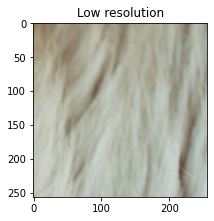

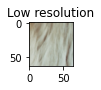

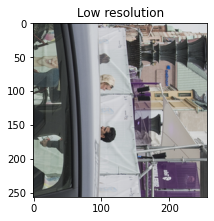

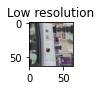

In [ ]:
for i in train.take(2):
  # lr,hr=random_crop(i[0],i[1],128,4)
  # print(i.shape)
  # print(hr.shape)
    # print(len(i[0].numpy()))
  dataset_loader.show(i[1][0],'Low resolution')
  dataset_loader.show(i[0][0],'Low resolution')
  # dataset_loader.show(generator(i[0])[0],'Low resolution')
  # dataset_loader.show(generator(tf.expand_dims(i[1],axis=0))[0],'High resolution')

In [ ]:
train = train.map(lambda lr,hr:( dataset_loader.normalize_img(lr),dataset_loader.normalize_img(hr)), num_parallel_calls=tf.data.AUTOTUNE)

Normalizes images: `uint8` -> `float32`
Normalizes images: `uint8` -> `float32`


In [ ]:
for i in train.take(1):
  # print(len(i[0]))
    # print(len(i[0].numpy()))
  # print(tf.image.ssim(generator(i[0]),i[1],max_val=1))
  # print(content_loss(generator(i[0])[0],i[1][0]))
  # print(style_loss(generator(tf.expand_dims(i[0][0],axis=0)),tf.expand_dims(i[1][0],axis=0)))
  dataset_loader.show(tf.image.resize(i[0], [i[0].shape[0]*4,i[0].shape[1]*4], method=tf.image.ResizeMethod.BICUBIC),'Low resolution')
  dataset_loader.show(generator(tf.expand_dims(i[0],axis=0))[0],'Low resolution')
  dataset_loader.show(i[1],'High resolution')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
tf.expand_dims

#Compile Model

In [ ]:
import ModuleArchitecture as architecture
import tensorflow as tf

Building Generator model by calling API funciton from ModuleArchitecture notebook.

In [ ]:
generator = architecture.build_generator(kn_construc=7)

AttributeError: ignored

In [ ]:
tf.keras.utils.plot_model(generator, "generator.png", show_shapes=True, expand_nested=True)

In [ ]:
generator_separated = architecture.build_generator_separated(kn_construc=7)

AttributeError: ignored

/content/drive/.shortcut-targets-by-id/1YQRZ4J0XiIT4NXBt9kvXgpNEbEp588R7/Colab-Super_resolution


In [ ]:
tf.keras.utils.plot_model(generator_separated, "generator2.png", show_shapes=True, expand_nested=True)

First we need to train generator seperately with discriminator by MAE and then train it with feature loss and style loss, creating subclass model to do it.

In [ ]:
class Generator_implementation(tf.keras.Model):
  def __init__(self,generator,only_contentloss=True):
    super(Generator_implementation,self).__init__()
    self.generator=generator
    self.only_contentloss=only_contentloss
  def compile(
        self,
        content_loss,
        feature_loss,
        style_loss,
        alpha,
        beta,
        gamma,
        psnr,
        ssim,
        g_optimizer,
    ):
        super(Generator_implementation, self).compile()
        self.content_loss = content_loss
        self.feature_loss = feature_loss
        self.style_loss=style_loss
        self.g_optimizer = g_optimizer
        self.alpha=alpha
        self.beta=beta
        self.gamma=gamma
        self.psnr=psnr
        self.ssim=ssim
  def test_step(self,batch_data):
    low_img,high_img=batch_data
    super_img = self.generator(low_img)
    psnr_value = self.psnr(super_img, high_img)
    ssim_value = self.ssim(super_img, high_img)
    return {'psnr':psnr_value,'ssim':ssim_value }
  def train_step(self,batch_data):
    low_img,high_img=batch_data
    if(self.only_contentloss):
      with tf.GradientTape() as tape:
            super_img = self.generator(low_img)
            ct_loss = self.content_loss(super_img,high_img)
      grads = tape.gradient(ct_loss, self.generator.trainable_variables)
      self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))
      return {'content_loss':ct_loss}
    else:        
      with tf.GradientTape() as tape:
              super_img = self.generator(low_img)
              ct_loss = self.alpha*self.content_loss(super_img,high_img)
              ft_loss = self.beta*self.feature_loss(super_img,high_img)
              s_loss = self.gamma*self.style_loss(super_img,high_img)
              loss = ct_loss + ft_loss + s_loss
      grads = tape.gradient(loss, self.generator.trainable_variables)
      self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))
      return {'content_loss':ct_loss,
              'feature_loss':ft_loss,
              'style_loss':s_loss}

In [ ]:
generator_monitor=Generator_implementation(generator,only_contentloss=False)

**Compile model and creating the checkpoint for generator**

Content loss by MAE

In [ ]:
content_sloss=architecture.loss_compute(type='l2')
#content_loss=architecture.loss_compute(type='l2')

Feature loss from both high and low feature from VGG19

In [ ]:
feature_loss=architecture.build_featureloss()

Style loss from 4 layers (5th, 10th, 15th, 20th) 

In [ ]:
style_loss=build_styleloss()

In [ ]:
def build_styleloss(type_loss='l2',list_alpha=[0.25,0.25,0.25,0.25]):
  index_layer=[5,10,15,20]
  list_feature=[style_loss(type_loss=type_loss,index_layer=i) for i in index_layer]
  if(len(list_alpha)!=4):
     raise Exception("alphas length out of range 4")
  @tf.function
  def content_loss(sr,hr):
    return tf.reduce_sum([list_alpha[index]*style(sr,hr) for index,style in enumerate(list_feature)])
  return content_loss

In [ ]:
def style_loss(type_loss='l2', index_layer=5, with_activation=False):
    """style_loss"""
    loss_function=architecture.loss_compute(type=type_loss)
    extract_model=architecture.featuremap_vgg19(index=index_layer,with_activation=with_activation)
    def gram_matrix(input_tensor):
      result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
      input_shape = tf.shape(input_tensor)
      num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
      out_size=tf.cast(input_shape[1]*input_shape[2]*input_shape[3], tf.float32)
      return result/(num_locations),out_size
    @tf.function
    def content_loss(hr, sr):
        # the input scale range is [0, 1] (vgg is [0, 255]).
        # 12.75 is rescale factor for vgg featuremaps.
        preprocess_sr = tf.keras.applications.vgg19.preprocess_input(sr * 255.) 
        preprocess_hr = tf.keras.applications.vgg19.preprocess_input(hr * 255.) 
        sr_features,size = gram_matrix(extract_model(preprocess_sr))
        hr_features,size = gram_matrix(extract_model(preprocess_hr))
        return tf.reduce_sum(tf.square(sr_features-hr_features))/(4*size**2)
    return content_loss

Create the checkpoint for training generator processes

In [ ]:
ssim_metric = architecture.ssim_metrics()
psnr_metric =architecture.psnr_metrics()

In [ ]:
class Generator_implementation_Callbacks(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        print('\n'+str(logs))

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Colab-Super_resolution/Pretrained_data/Checkpoint_weight/Generator/ckpt"
g_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
ckpt = tf.train.Checkpoint(step=tf.Variable(0),generator=generator ,g_optimizer=g_optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)
generator_callback=Checkpoint_callbacks(ckpt=ckpt,manager=ckpt_manager,epochs=20)

In [ ]:
save_path = ckpt_manager.save()

In [ ]:
ckpt.g_optimizer.learning_rate=2e-6

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=2e-06>

In [ ]:
ckpt.step

In [ ]:
ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
ckpt.g_optimizer.learning_rate=2e-6

In [ ]:
generator_monitor.compile(
    content_loss=content_sloss,
    g_optimizer=g_optimizer,
    feature_loss=feature_loss,
    style_loss=style_loss,
    alpha=1,
    beta=2e-4,
    gamma=2e-4,
    psnr=psnr_metric,
    ssim=ssim_metric)

In [ ]:
callback_monitor=Generator_implementation_Callbacks()

In [ ]:
csv_logger = tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/Colab-Super_resolution/Pretrained_data/Logger_History/Stage1/ESRGAN1.csv',',',append=True)

In [ ]:
len(train)

200

In [ ]:
len(validate)

25

In [ ]:
history=generator_monitor.fit(train.take(50),epochs=50,initial_epoch=40,validation_data=validate.take(5),callbacks=[callback_monitor,generator_callback,csv_logger])

Restored from /content/drive/MyDrive/Colab-Super_resolution/Pretrained_data/Checkpoint_weight/Generator/ckpt/ckpt-8
Epoch 41/50


50/50 [==============================] - ETA: 0s - content_loss: 0.0047 - feature_loss: 0.1321 - style_loss: 0.8755
{'content_loss': 0.003508743830025196, 'feature_loss': 0.11116037517786026, 'style_loss': 0.7118144631385803, 'val_psnr': 27.77249526977539, 'val_ssim': 0.7305881977081299}
50/50 [==============================] - 258s 4s/step - content_loss: 0.0047 - feature_loss: 0.1317 - style_loss: 0.8723 - val_psnr: 27.7725 - val_ssim: 0.7306
Epoch 42/50
50/50 [==============================] - ETA: 0s - content_loss: 0.0042 - feature_loss: 0.1187 - style_loss: 0.6024
{'content_loss': 0.004766569938510656, 'feature_loss': 0.1368662267923355, 'style_loss': 0.745485246181488, 'val_psnr': 25.130374908447266, 'val_ssim': 0.6759663820266724}
50/50 [==============================] - 211s 4s/step - content_loss: 0.0042 - feature_loss: 0.1191 - style_loss: 0.6052 - val_psnr: 25.1304 - val_ssim: 0.6760
Epoch 43/50
50/50 [==============================] - ETA: 0s - content_loss: 0.0046 - featu

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd

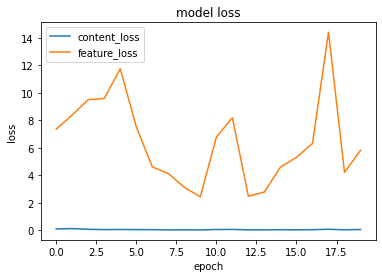

In [ ]:
plt.plot(history.history['content_loss'])
plt.plot(history.history['feature_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['content_loss', 'feature_loss'], loc='upper left')
plt.show()

In [ ]:
his = pd.read_csv(
    "/content/drive/MyDrive/Colab-Super_resolution/Pretrained_data/Logger_History/Stage1/ESRGAN1.csv")

In [ ]:
discriminator = architecture.build_discriminator()

In [ ]:
class GAN(tf.keras.Model):
  def __init__(self,discriminator,generator):
    super(GAN,self).__init__()
    self.discriminator=discriminator
    self.generator=generator
  def compile(
        self,
        content_loss,
        feature_loss,
        style_loss,
        g_loss,
        d_loss,
        g_optimizer,
        d_optimizer
    ):
        super(GAN, self).compile()
        self.content_loss = content_loss
        self.feature_loss = feature_loss
        self.style_loss = style_loss
        self.g_loss = g_loss
        self.d_loss = d_loss
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
  def train_step(self,batch_data):
    print(type(batch_data))
    low_img,high_img=batch_data
    with tf.GradientTape(persistent=True) as tape:
       super_img=self.generator(low_img)
       predict_sr=self.discriminator(super_img)
       predict_hr=self.discriminator(high_img)
       ct_loss=self.content_loss(super_img,high_img) 
       ft_loss=self.feature_loss(super_img,high_img)
       st_loss=self.style_loss(super_img,high_img)
       g_loss=self.g_loss(predict_sr,predict_hr)
       generator_loss= ct_loss + ft_loss + st_loss + g_loss
       d_loss=self.d_loss(predict_sr,predict_hr)
    grads_G = tape.gradient(
            generator_loss, generator.trainable_variables)
    grads_D = tape.gradient(
            d_loss, discriminator.trainable_variables) 
    self.g_optimizer.apply_gradients(
            zip(grads_G, generator.trainable_variables))
    self.d_optimizer.apply_gradients(
            zip(grads_D, discriminator.trainable_variables))
    return {
        'content_loss':ct_loss,
        'feature_loss':ft_loss,
        'style_loss':st_loss,
        'g_loss':g_loss,
        'd_loss':d_loss,
        'gan_loss':g_loss+d_loss
    }


In [ ]:
gan = GAN(generator=generator,discriminator=discriminator)
content_loss=architecture.loss_compute(type='l2')
feature_loss=architecture.feature_loss()
style_loss=architecture.style_loss()
g_loss=architecture.generator_loss()
d_loss=architecture.discriminator_loss()
d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
gan.compile(content_loss=content_loss,feature_loss=feature_loss,style_loss=style_loss,g_loss=g_loss,d_loss=d_loss,d_optimizer=d_optimizer,g_optimizer=g_optimizer)

In [ ]:
gan.fit(ds,epochs=2)

#Implement checkpoint and restored model

In [ ]:
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=net, iterator=iterator)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=3)

In [ ]:
class Checkpoint_callbacks(tf.keras.callbacks.Callback):
    def __init__(self,manager,ckpt,epochs=10):
      self.manager=manager
      self.ckpt=ckpt
      self.epochs=epochs
    def on_train_begin(self, logs=None):
      self.ckpt.restore(self.manager.latest_checkpoint)
      if self.manager.latest_checkpoint:
          print("Restored from {}".format(self.manager.latest_checkpoint))
      else:
          print("Initializing from scratch.")
    def on_epoch_end(self, epoch, logs=None):
     self.ckpt.step.assign_add(1)
     if int(self.ckpt.step) % self.epochs == 0:
      save_path = self.manager.save()
      print("\nSaved checkpoint for step {}: {}".format(int(self.ckpt.step), save_path))

In [ ]:
class Gan_Callbacks(tf.keras.callbacks.Callback):
    def __init__(self,manager):
      self.manager=manager
    def on_epoch_end(self, epoch, logs=None):
        print(logs)

#Implement Training Step
 